This notebook covers the basics of operations on Series and DataFrames. Again, a quick check on whether you know the material.

1. Can you use numpy ufuncs (e.g. `np.exp`) on DataFrames?
2. What happens when you add two DataFrames with different indicies?

If you know the answers already, you can skip to our first [application](Application:-Economic-Timeseries). Maybe donwload some additional datasets from FRED and play with those.

`DataFrame`s and `Series` support all the usual math operations, addition, multiplaction, etc.
numpy `ufuncs` e.g. `np.log` can also be used as expected.

In [2]:
import numpy as np
import pandas as pd

In [3]:
np.random.seed(42)
df = pd.DataFrame(np.random.uniform(0, 10, size=(3, 3)))

In [4]:
df + 1

,0,1,2
0,4.745401,10.507143,8.319939
1,6.986585,2.560186,2.559945
2,1.580836,9.661761,7.011150


In [5]:
df ** 2

,0,1,2
0,14.028030,90.385769,53.581513
1,35.839198,2.434182,2.433429
2,0.337371,75.026112,36.133926


In [6]:
np.log(df)

,0,1,2
0,1.320529,2.252043,1.990602
1,1.789521,0.444805,0.444651
2,-0.543287,2.158918,1.793616


But we don't just have NumPy arrays. We have `DataFrames` and `Series`, which have *labels*.
Pandas automatically aligns by label when doing operations between `DataFrames` and `Series`.

In [8]:
df1 = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
df2 = pd.DataFrame({'A': [2, 4, 6], 'B': [1, 4, 9]})

df1 + df2

,A,B
0,3,5
1,6,9
2,9,15


In [9]:
# Note the index order
df2 = pd.DataFrame({'A': [2, 4, 6], 'B': [1, 4, 9]}, index=[2, 0, 1])
df2

,A,B
2,2,1
0,4,4
1,6,9


In [11]:
df1 + df2

,A,B
0,5,8
1,8,14
2,5,7


In [12]:
# Different index entirely
df3 = pd.DataFrame(np.random.randn(5, 3), columns=['A', 'B', 'C'])
df3

,A,B,C
0,-0.580878,-0.525170,-0.571380
1,-0.924083,-2.612549,0.950370
2,0.816445,-1.523876,-0.428046
3,-0.742407,-0.703344,-2.139621
4,-0.629475,0.597720,2.559488


In [13]:
df1 + df3

,A,B,C
0,0.419122,3.474830,NaN
1,1.075917,2.387451,NaN
2,3.816445,4.476124,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


# Application: Economic Timeseries

In [14]:
from itertools import chain

import pandas as pd

import seaborn as sns
import statsmodels.api as sm
from pandas_datareader import data
# from pandas.io import data
from cytoolz import partitionby

%matplotlib inline
%config InlineBackend.figure_format = 'png'
pd.options.display.max_rows = 10
sns.set_style('ticks')

Pandas recently split off some web-based data reading functionality into its own package `pandas-datareader`. We'll use it to grab data from [FRED](http://research.stlouisfed.org).

In [15]:
gdp = data.DataReader("GDP", data_source='fred', start='1929', end='2014') 

```python
gdp = data.DataReader("GDPA", data_source='fred', start='1929', end='2014').squeeze()
cpi = data.DataReader("CPIAUCSL", data_source='fred', start='1947-01', end='2015-05').squeeze()
rec = data.DataReader('USREC', data_source='fred', start='1854-12-01', end='2014-08-01').squeeze()
gdp.to_csv('data/gdp.csv', header=True)
cpi.to_csv('data/cpi.csv', header=True)
rec.to_csv('data/rec.csv', header=True)
```

In [16]:
# gdp = pd.read_csv('data/gdp.csv', index_col='DATE', parse_dates=True).squeeze()
cpi = pd.read_csv('data/cpi.csv', index_col='DATE', parse_dates=True).squeeze()
rec = pd.read_csv('data/rec.csv', index_col='DATE', parse_dates=True).squeeze()

I almost always start my analysis by viewing the data, in table form...

In [22]:
gdp.head()

DATE
1947-01-01    243.1
1947-04-01    246.3
1947-07-01    250.1
1947-10-01    260.3
1948-01-01    266.2
Name: GDP, dtype: float64

In [23]:
cpi.head()

DATE
1947-01-01    21.48
1947-02-01    21.62
1947-03-01    22.00
1947-04-01    22.00
1947-05-01    21.95
Name: CPIAUCSL, dtype: float64

In [24]:
rec.head()

DATE
1854-12-01    1
1855-01-01    0
1855-02-01    0
1855-03-01    0
1855-04-01    0
Name: USREC, dtype: int64

... with summary stats

In [25]:
gdp.describe()

count      269.000000
mean      5074.190335
std       5158.153013
min        243.100000
25%        654.800000
50%       2860.000000
75%       8551.900000
max      17078.300000
Name: GDP, dtype: float64

`Describe` actually combines and few different *aggregation* methods that summarise a DataFrame or Series. These include `mean`, `max`, `std`, `quantile`...

In [26]:
print('mean:    ', gdp.mean())
print('std:     ', gdp.std())
print('quantile:', gdp.quantile(.66))

mean:     5074.1903345724895
std:      5158.153012839137
quantile: 6132.956


And finally, visually. We'll do just a bit of work to get `rec` the recession indicator, in a form suitable for matplotlib.

The only pandas-relavent bit is `Series.iteritems`, which you *almost* never want to use since it's relatively slow.

In [27]:
next(rec.iteritems())  

(Timestamp('1854-12-01 00:00:00'), 1)

In [28]:
groups = partitionby(lambda x: x[1] == 1, rec.iteritems())
recessions = filter(lambda x: x[0][1] == 1, groups)
spans = [(months[0][0], months[-1][0]) for months in recessions]

In [29]:
def add_rec_bars(ax=None):
    ax = ax or plt.gca()
    for span in spans:
        ax.fill_between(span, *ax.get_ylim(), color='k', alpha=.25)
    return ax

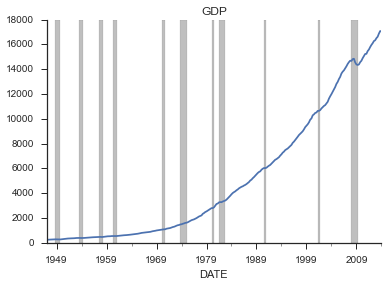

In [30]:
ax = gdp.plot(title='GDP')
add_rec_bars(ax)
sns.despine()

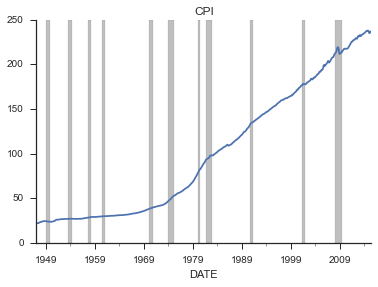

In [31]:
ax = cpi.plot(title='CPI')
add_rec_bars(ax)
sns.despine()

Let's put some of those operations to use.

First off, we'll convert the CPI base-2009 by dividing the Series by the average CPI in 2009.

In [32]:
# You *could* do this...
cpi.loc[pd.Timestamp('2009-01-01'):pd.Timestamp('2009-12-31')].mean()

214.56466666666668

In [33]:
# but timeseries (Series or DataFrames with a DatetimeIndex) are special 
base_09 = cpi.loc['2009'].mean()
base_09

214.56466666666668

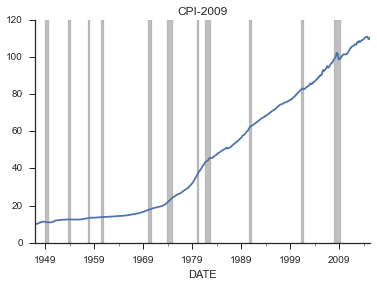

In [37]:
cpi09 = cpi / base_09 * 100
ax = cpi09.plot(title='CPI-2009')
add_rec_bars(ax=ax)
sns.despine();

# Alignment

We've been adding numbers and doing `ufuncs` on DataFrames and Series. Big deal, right?

Let's say we want real GDP (adjusted for inflation).

\begin{equation}
    rGDP_t = \frac{GDP_t}{CPI_t}
\end{equation}

Problem: our CPI is monthly but GDP is annual. Also the GDP series starts and stops before CPI. If you didn't have automatic label alignment, you'd have to jump through hoops to select the correct subset of each series.


```python
# this is boolean indexing, we'll see more later
gdp / cpi09[(cpi09.index.month == 1) & (cpi09.index.year <= 2014)]
```

... but that's unneccesary. The operations will automatically align for you.

In [41]:
rgdp = (gdp / cpi09)
rgdp.loc['1947']

DATE
1947-01-01    24.283366
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    24.021490
1947-05-01          NaN
                ...    
1947-08-01          NaN
1947-09-01          NaN
1947-10-01    24.378517
1947-11-01          NaN
1947-12-01          NaN
dtype: float64

The `NaN`s are missing value indicators. `NaN`s can crop up for many reasons, but in this case it's because the labels didn't overlap perfectly.

Many pandas methods, e.g. aggregations like `sum` or `mean`, will ignore missing values

Or you can explicitly drop them, which is what I'll do here.

In [45]:
rgdp.dropna()

DATE
1947-01-01     24.283366
1947-04-01     24.021490
1947-07-01     24.139732
1947-10-01     24.378517
1948-01-01     24.120403
                 ...    
2013-01-01    152.988712
2013-04-01    153.919900
2013-07-01    155.386704
2013-10-01    156.663221
2014-01-01    155.534015
dtype: float64

Pandas methods are non-mutating by default. This means that even though I called `.dropna()` above, `rgdp` still has missing values.

In [43]:
rgdp

DATE
1947-01-01    24.283366
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    24.021490
1947-05-01          NaN
                ...    
2015-01-01          NaN
2015-02-01          NaN
2015-03-01          NaN
2015-04-01          NaN
2015-05-01          NaN
dtype: float64

To capture the change, assign a name to the result. In this case, I just the same name `rgdp`.

In [44]:
rgdp = rgdp.dropna()
rgdp.head()

DATE
1947-01-01    24.283366
1947-04-01    24.021490
1947-07-01    24.139732
1947-10-01    24.378517
1948-01-01    24.120403
dtype: float64

In [56]:
import matplotlib.pyplot as plt

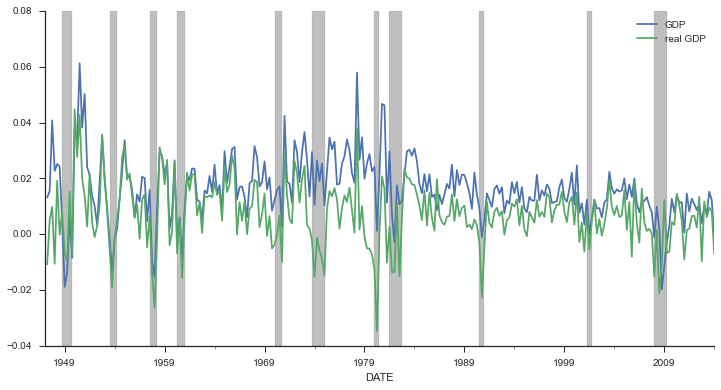

In [60]:
ax = gdp.pct_change().plot(figsize=(12, 6), label='GDP', legend=True)
rgdp.pct_change().plot(ax=ax, label='real GDP', legend=True)
add_rec_bars(ax)
sns.despine()
# plt.legend();